In [1]:
import polars as pl
import plotly.express as px
import pyarrow
import numpy as np
import scipy.stats

In [2]:
total_genome_length = 1148597545

In [54]:
# We only want the "RG" lines for ROH from bcftools

#!grep "^RG" ../CircosPlot/data/bcftoolsroh > roh_data

In [65]:
data = pl.read_csv("roh_data", comment_char = "#", separator = "\t", has_header=False, new_columns = ["Type", "Sample", "Chr", "Start", "End", "Length", "NumMarkers", "Quality"])
data.head()

Type,Sample,Chr,Start,End,Length,NumMarkers,Quality
str,str,str,i64,i64,i64,i64,f64
"""RG""","""Adelaide""","""S1""",715348,789971,74624,261,61.9
"""RG""","""Adelaide""","""S1""",967118,1001915,34798,147,12.8
"""RG""","""Adelaide""","""S1""",1228034,1240431,12398,104,29.6
"""RG""","""Adelaide""","""S1""",1316518,1347128,30611,126,53.1
"""RG""","""Adelaide""","""S1""",2251310,2304273,52964,234,57.8


In [66]:
founders = pl.read_csv("../CircosPlot/founder_names", has_header=False, new_columns=["ID"])
offspring = pl.read_csv("../CircosPlot/offspring_names", has_header=False, new_columns=["ID"])
founders = list(founders["ID"])
offspring = list(offspring["ID"])
#len(founders)

In [67]:
data = data.with_columns([
    (pl.col("Sample").is_in(founders)).alias("Founder")
])

#founders_data = data.filter(pl.col("Sample").is_in(founders))
#offspring_data = data.filter(pl.col("Sample").is_in(offspring))
#founders_data.head()
data

Type,Sample,Chr,Start,End,Length,NumMarkers,Quality,Founder
str,str,str,i64,i64,i64,i64,f64,bool
"""RG""","""Adelaide""","""S1""",715348,789971,74624,261,61.9,false
"""RG""","""Adelaide""","""S1""",967118,1001915,34798,147,12.8,false
"""RG""","""Adelaide""","""S1""",1228034,1240431,12398,104,29.6,false
"""RG""","""Adelaide""","""S1""",1316518,1347128,30611,126,53.1,false
"""RG""","""Adelaide""","""S1""",2251310,2304273,52964,234,57.8,false
"""RG""","""Adelaide""","""S1""",2548361,2724203,175843,450,26.3,false
"""RG""","""Adelaide""","""S1""",3510914,3905758,394845,1244,87.0,false
"""RG""","""Adelaide""","""S1""",4145398,4284244,138847,445,51.1,false
"""RG""","""Adelaide""","""S1""",4315410,4319257,3848,42,21.5,false


In [58]:
data_agg = data.groupby("Sample").agg([pl.sum("Length")/total_genome_length, pl.count(), pl.first("Founder")])
data_agg.head()

Sample,Length,count,Founder
str,f64,u32,bool
"""Tumeke""",0.415237,1137,false
"""Aranga""",0.455237,1019,false
"""Awhero""",0.323235,1355,false
"""Te_Here""",0.452668,1062,false
"""Hauturu""",0.433597,935,false


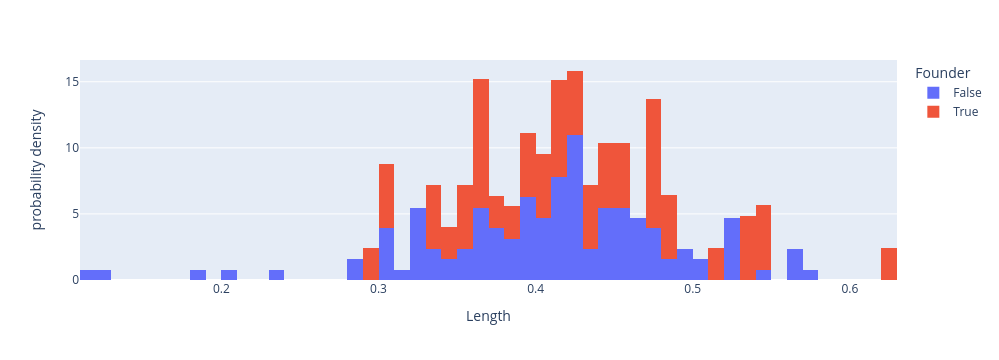

In [59]:
px.histogram(data_agg.to_pandas(), color="Founder", x="Length", nbins=80, histnorm='probability density')

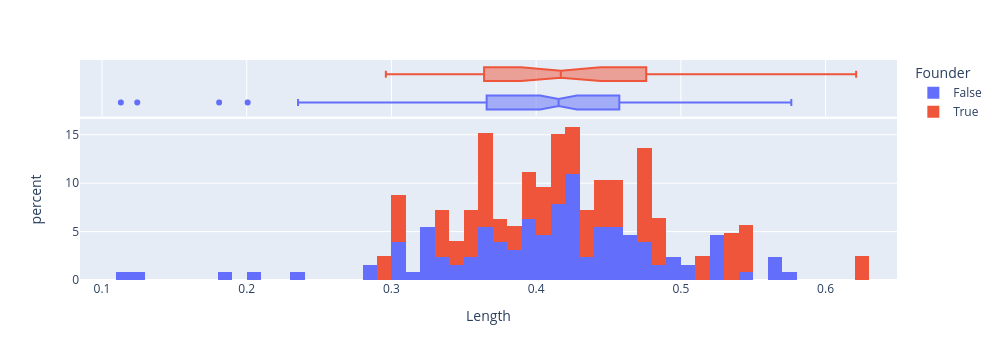

In [60]:
px.histogram(data_agg.to_pandas(), color="Founder", x="Length", nbins=80, histnorm='percent', marginal="box")

# Get Lengths

In [61]:
founders_length = data.filter(pl.col("Founder") == True)["Length"].to_list()
[min(founders_length), np.mean(founders_length), max(founders_length), np.median(founders_length)]

[307, 442093.3708663509, 115478915, 87906.5]

In [62]:
offspring_length = data.filter(pl.col("Founder") == False)["Length"].to_list()
[min(offspring_length), np.mean(offspring_length), max(offspring_length), np.median(offspring_length)]

[372, 419093.9188060787, 73089506, 91152.0]

In [63]:
len(set(data.filter(pl.col("Founder") == True)['Sample'].to_list()))

41

In [64]:
len(set(data.filter(pl.col("Founder") == False)['Sample'].to_list()))

128

# Run F-test

In [68]:
founder_roh = data_agg.filter(pl.col("Founder") == True)["Length"].to_list()
offspring_roh = data_agg.filter(pl.col("Founder") == False)["Length"].to_list()

In [72]:
scipy.stats.ttest_ind(founder_roh, offspring_roh)

Ttest_indResult(statistic=1.1700644591078977, pvalue=0.24364213449491934)

In [77]:
scipy.stats.ttest_ind(data.filter(pl.col("Founder") == True)['Length'].to_list(), data.filter(pl.col("Founder") == False)['Length'].to_list())

Ttest_indResult(statistic=2.1024577603532144, pvalue=0.03551452108929415)

In [78]:
scipy.stats.f_oneway(data.filter(pl.col("Founder") == True)['Length'].to_list(), data.filter(pl.col("Founder") == False)['Length'].to_list())

F_onewayResult(statistic=4.420328634069455, pvalue=0.03551452109933318)

In [82]:
#px.histogram(data.to_pandas(), color="Founder", x="Length", nbins=80, histnorm='percent', marginal="box")